## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Импортируем необходимое


In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

# Загружаем данные

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Предобработка данных

## Смотрим кол-во пропущенных значений

In [5]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

## Приводим столбцы к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()

## Рассмотрим пропущенные значения подробнее

### Столбец name

In [7]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


### столбец genre

In [8]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [9]:
df[df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Данные строки являются взаимосвязанными и их удаление никак не повлияет на наш анализ

In [10]:
df.dropna(subset=['genre', 'name'], inplace=True)

### столбец year_of_release

In [11]:
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [12]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [13]:
print('Количество пропущенных значений в столбце year_of_release')
print((df['year_of_release'].isnull().sum() / len(df['name'])*100).round(3), ('%'))
df = df.dropna(subset=['year_of_release'])

Количество пропущенных значений в столбце year_of_release
1.61 %


Так как значение не велико, можно данные строки удалить

### столбец user_score

In [14]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

tbd - Будет определено

In [15]:
# Заменим пропущенные значения и tbd на 0
df.loc[df['user_score'] == 'tbd', 'user_score'] = 0
df['user_score'].fillna('0' , inplace = True)

### столбцы critic_score и rating

In [16]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [17]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Так как столбец рейтинг ESRB категориальный, то лучшей заменой будет простановка константы - tbd

Столбец critic_store содержит оценку критиков в стобалльной шкале оценок, если пропуск то заменить лучше на 0, что будет означать, что критики нет для данной игры.

In [18]:
df['rating'].fillna('tbd', inplace=True)
df['critic_score'].fillna(0, inplace=True)

In [19]:
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Пропущенные значения были успешно обработаны :)

# Проверка на дубликаты

In [20]:
df.duplicated().sum()

0

In [21]:
duplicates = df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]
duplicates


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [22]:
df.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first', inplace=True)


# Суммарные продажи во всех регионах

In [23]:
df['sum_sales'] = df[["na_sales" ,"eu_sales", "jp_sales", "other_sales"]].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,0,tbd,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,tbd,31.38


# Приведем столбцы к правильному типу

In [24]:
df['year_of_release'] = (df['year_of_release']).astype('int')
df['critic_score'] = (df['critic_score']).astype('int')
df['user_score'] = (df['user_score']).astype('float')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  sum_sales        16443 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


In [26]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,tbd,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,tbd,31.38


# Шаг 3.1 Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [27]:

games_per_year = df['year_of_release'].value_counts().sort_index()
games_per_year


1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: year_of_release, dtype: int64

С 1980 года количество выпускаемых игр постепенно росло, начиная с десятков игр и достигнув пика в 2008–2009 годах (свыше 1400 игр ежегодно).
После 2010 года количество игр снижается, что может быть связано с изменениями в игровой индустрии, включая переход к цифровой дистрибуции и рост популярности мобильных игр.

Данные за более ранние периоды могут быть менее полезными из-за небольшого объёма и изменений в индустрии. Для более значимых выводов целесообразно сосредоточиться на данных с 2000-х годов

# Шаг 3.2 Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [28]:

sales_by_platform = df.groupby('platform')['sum_sales'].sum().sort_values(ascending=False)

top_platforms = sales_by_platform.head(5).index.tolist()
top_platforms


['PS2', 'X360', 'PS3', 'Wii', 'DS']

Нашли топ-5 платформ по суммарным продажам

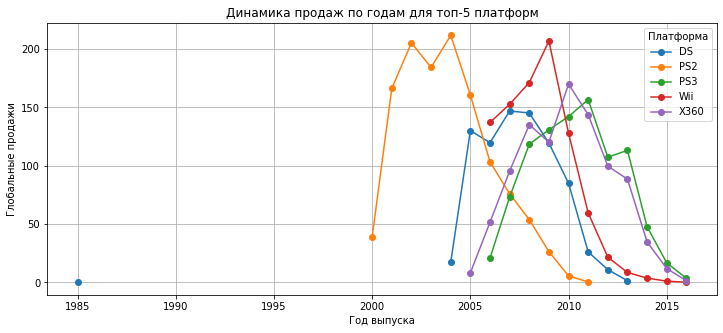

In [29]:
df_top = df[df['platform'].isin(top_platforms)]
pivot = df_top.pivot_table(index='year_of_release', 
                           columns='platform', 
                           values='sum_sales', 
                           aggfunc='sum')
plt.figure(figsize=(12, 5))
for platform in pivot.columns:
    plt.plot(pivot.index, pivot[platform], marker='o', label=platform)
plt.xlabel('Год выпуска')
plt.ylabel('Глобальные продажи')
plt.title('Динамика продаж по годам для топ-5 платформ')
plt.legend(title='Платформа')
plt.grid(True)
plt.show()

Нашли динамику продаж по годам для топ 5 платформ

In [30]:
time_life = df.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['lifelongness'] = time_life['max'] - time_life['min']+1
time_life.head()


,platform,min,max,lifelongness
,,year_of_release,year_of_release,
0,2600,1980,1989,10
1,3DO,1994,1995,2
2,3DS,2011,2016,6
3,DC,1998,2008,11
4,DS,1985,2013,29


In [31]:
time_life['lifelongness'].median()

7.0

С помощью сводной таблицы мы рассчитали медианное значение продолжительности жизни платформы - 7


Здесь стоит сослаться на жизненный цикл, что половина от него уходит на развитие платформы, а половина на спад. Поэтому стоит брать срок, за который платформы  от появления достигают пика. К тому же в 2013 появляются самые актуальные поколения платформ, поэтому брать период гораздо раньший не стоит

# Шаг 3.3 Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.



In [32]:
df_actual = df[df['year_of_release'] > 2011]

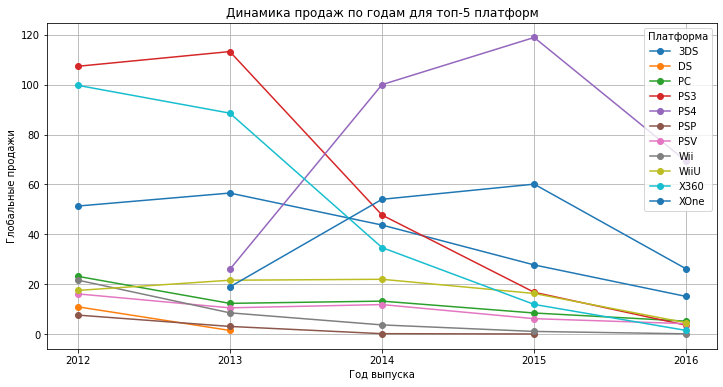

In [33]:
pivot2 = (
    df_actual.pivot_table(index = 'year_of_release',
                          columns = 'platform',
                          values = 'sum_sales',
                          aggfunc='sum')
)
plt.figure(figsize=(12, 6))
for platform in pivot2.columns:
    plt.plot(pivot2.index, pivot2[platform], marker='o', label=platform)
plt.xlabel('Год выпуска')
plt.ylabel('Глобальные продажи')
plt.title('Динамика продаж по годам для топ-5 платформ')
plt.xticks(pivot2.index)
plt.legend(title='Платформа')
plt.grid(True)
plt.show()

Согласно графику, к 2016 году продажи консолей не растут – наблюдается спад на всех моделях. Наиболее перспективными остаются PS4 и XOne, хотя и у них также прослеживается снижение продаж

# Шаг 3.4 Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

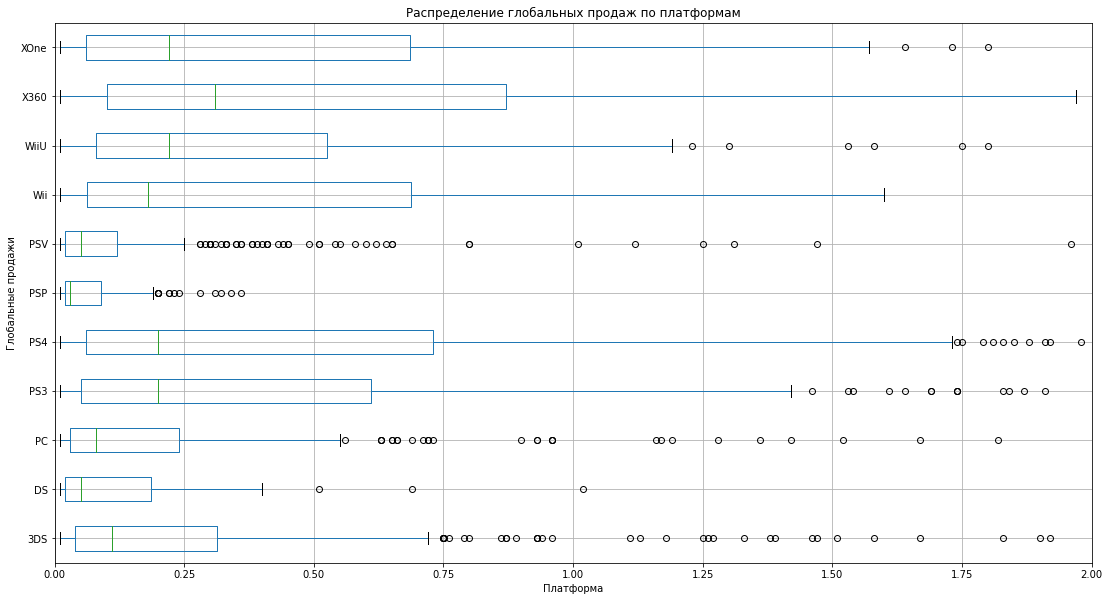

Медиана суммарных продаж по платформам: 0.18


In [34]:

plt.rcParams["figure.figsize"] = (18, 10)
df_actual.boxplot(column='sum_sales', by='platform', grid=True, vert=False)
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.title('Распределение глобальных продаж по платформам')
plt.xlim(0, 2)
plt.suptitle('') 
plt.show()
platform_total_sales = df_actual.groupby('platform')['sum_sales'].median()

overall_median = platform_total_sales.median()

print("Медиана суммарных продаж по платформам:", overall_median)



Медианное значение по всей выборке составляет 0,18 но у большинства консолей данный показатель не совпадает с основным.


# Шаг 3.5 Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Соотнесите выводы с продажами игр на других платформах.

### PS4

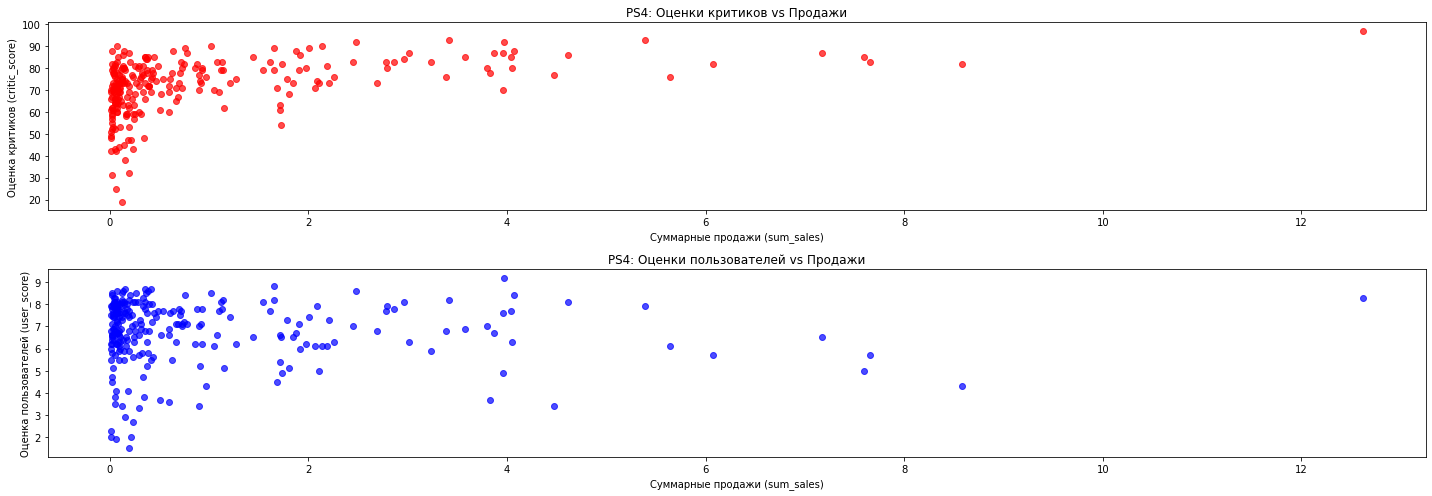

Корреляция между суммарными продажами и оценками критиков для PS4: 0.40589480145836687
Корреляция между суммарными продажами и оценками пользователей для PS4: -0.03362497596528878


In [52]:
df_ps4 = df_actual.query('platform == "PS4" and user_score > 0 and critic_score > 0').dropna()

fig_scatter, (scatter_ax, scatter_ax2) = plt.subplots(2, 1, figsize=(20, 7))

scatter_ax.scatter(df_ps4['sum_sales'], df_ps4['critic_score'], color='red', alpha=0.7)
scatter_ax.set_xlabel('Суммарные продажи (sum_sales)')
scatter_ax.set_ylabel('Оценка критиков (critic_score)')
scatter_ax.set_title('PS4: Оценки критиков vs Продажи')

scatter_ax2.scatter(df_ps4['sum_sales'], df_ps4['user_score'], color='blue', alpha=0.7)
scatter_ax2.set_xlabel('Суммарные продажи (sum_sales)')
scatter_ax2.set_ylabel('Оценка пользователей (user_score)')
scatter_ax2.set_title('PS4: Оценки пользователей vs Продажи')

plt.tight_layout()
plt.show()

corr_critic = df_ps4['sum_sales'].corr(df_ps4['critic_score'])
corr_user = df_ps4['sum_sales'].corr(df_ps4['user_score'])

print("Корреляция между суммарными продажами и оценками критиков для PS4:", corr_critic)
print("Корреляция между суммарными продажами и оценками пользователей для PS4:", corr_user)


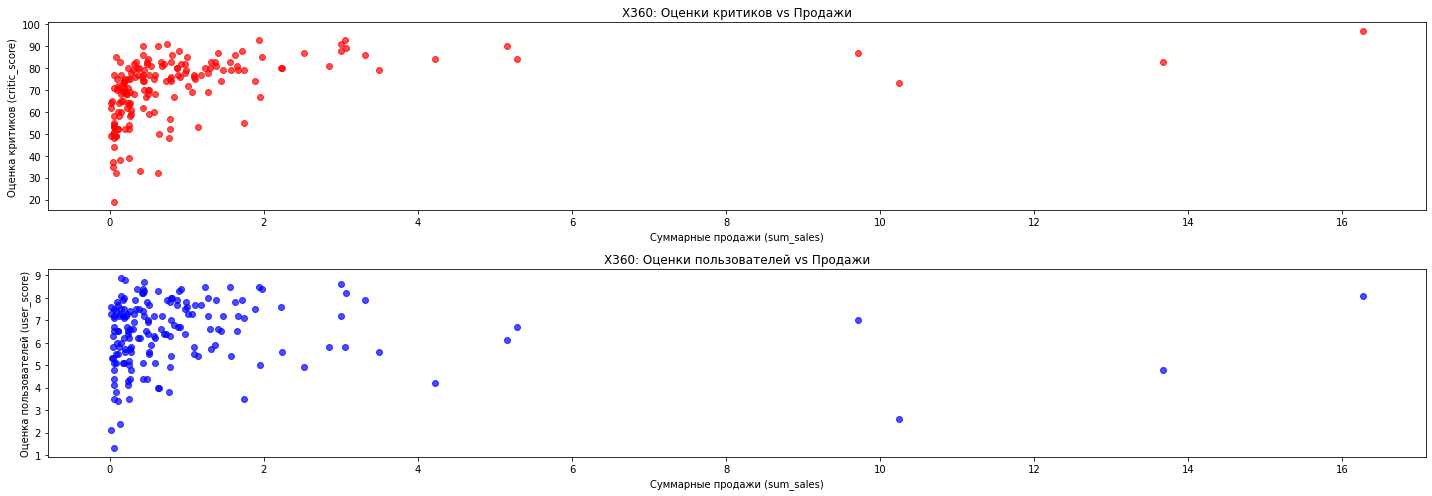

Корреляция между суммарными продажами и оценками критиков для X360: 0.36057348885073365
Корреляция между суммарными продажами и оценками пользователей для X360: -0.0020140394826897853


In [36]:
df_X360 = df_actual.query('platform == "X360" and user_score > 0 and critic_score > 0').dropna()

fig_scatter, (scatter_ax, scatter_ax2) = plt.subplots(2, 1, figsize=(20, 7))

scatter_ax.scatter(df_X360['sum_sales'], df_X360['critic_score'], color='red', alpha=0.7)
scatter_ax.set_xlabel('Суммарные продажи (sum_sales)')
scatter_ax.set_ylabel('Оценка критиков (critic_score)')
scatter_ax.set_title('X360: Оценки критиков vs Продажи')

scatter_ax2.scatter(df_X360['sum_sales'], df_X360['user_score'], color='blue', alpha=0.7)
scatter_ax2.set_xlabel('Суммарные продажи (sum_sales)')
scatter_ax2.set_ylabel('Оценка пользователей (user_score)')
scatter_ax2.set_title('X360: Оценки пользователей vs Продажи')

plt.tight_layout()
plt.show()

corr_critic = df_X360['sum_sales'].corr(df_X360['critic_score'])
corr_user = df_X360['sum_sales'].corr(df_X360['user_score'])

print("Корреляция между суммарными продажами и оценками критиков для X360:", corr_critic)
print("Корреляция между суммарными продажами и оценками пользователей для X360:", corr_user)

### XOne

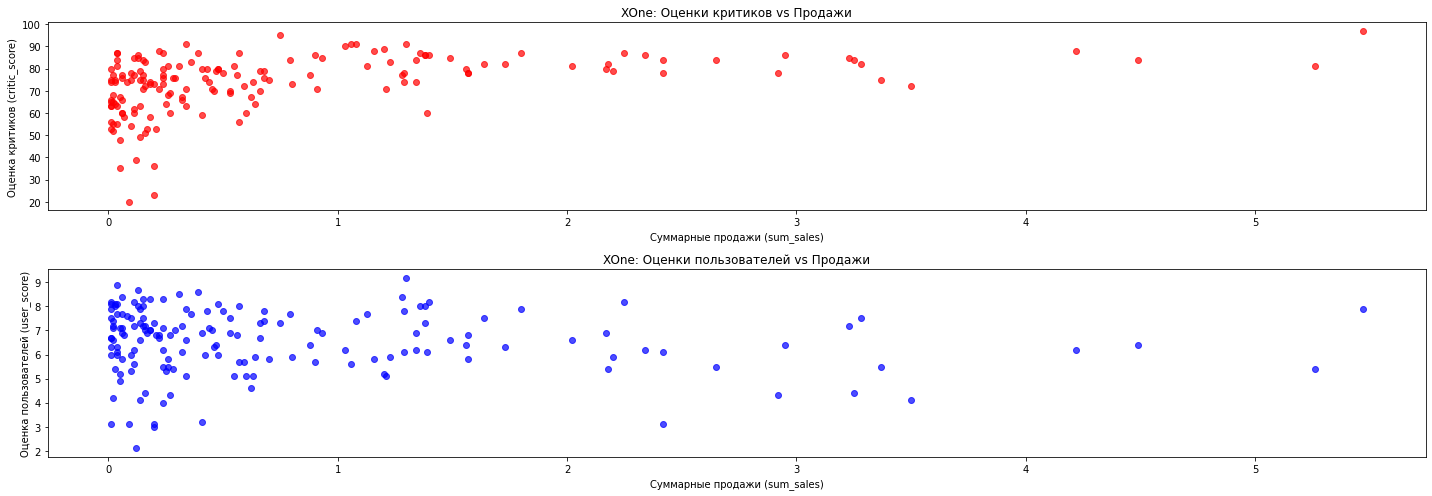

Корреляция между суммарными продажами и оценками критиков для XOne: 0.4104220356129637
Корреляция между суммарными продажами и оценками пользователей для XOne: -0.09400318326920852


In [37]:
df_XOne = df_actual.query('platform == "XOne" and user_score > 0 and critic_score > 0').dropna()

fig_scatter, (scatter_ax, scatter_ax2) = plt.subplots(2, 1, figsize=(20, 7))

scatter_ax.scatter(df_XOne['sum_sales'], df_XOne['critic_score'], color='red', alpha=0.7)
scatter_ax.set_xlabel('Суммарные продажи (sum_sales)')
scatter_ax.set_ylabel('Оценка критиков (critic_score)')
scatter_ax.set_title('XOne: Оценки критиков vs Продажи')

scatter_ax2.scatter(df_XOne['sum_sales'], df_XOne['user_score'], color='blue', alpha=0.7)
scatter_ax2.set_xlabel('Суммарные продажи (sum_sales)')
scatter_ax2.set_ylabel('Оценка пользователей (user_score)')
scatter_ax2.set_title('XOne: Оценки пользователей vs Продажи')

plt.tight_layout()
plt.show()

corr_critic = df_XOne['sum_sales'].corr(df_XOne['critic_score'])
corr_user = df_XOne['sum_sales'].corr(df_XOne['user_score'])

print("Корреляция между суммарными продажами и оценками критиков для XOne:", corr_critic)
print("Корреляция между суммарными продажами и оценками пользователей для XOne:", corr_user)

## *Вывод*

Зависимость между продажами и отзывами пользователей близка к нулю. 

Зависимость между продажами и оценкой критиков слабая, корреляция меньше 0.5.

# Шаг 3.6 Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?



In [38]:
df_actual.pivot_table(index = 'genre' , values='sum_sales', aggfunc=['count','sum', 'median'])


,count,sum,median
,sum_sales,sum_sales,sum_sales
genre,,,
Action,1031,441.12,0.120
Adventure,302,29.43,0.030
Fighting,109,44.49,0.130
Misc,192,85.04,0.120
Platform,85,61.00,0.210
Puzzle,28,4.89,0.045
Racing,115,53.50,0.140
Role-Playing,370,192.80,0.140


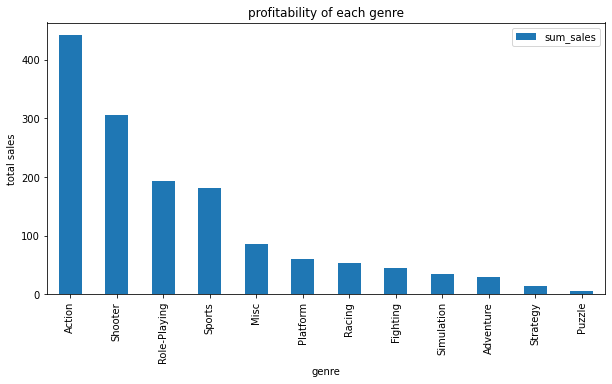

In [39]:
(df_actual
 .pivot_table(index='genre', values='sum_sales', aggfunc='sum')
 .sort_values(by='sum_sales',ascending=False)
 .plot(kind='bar', y='sum_sales', figsize=(10, 5),title = 'profitability of each genre')
 .set(xlabel='genre', ylabel='total sales'))
plt.show()

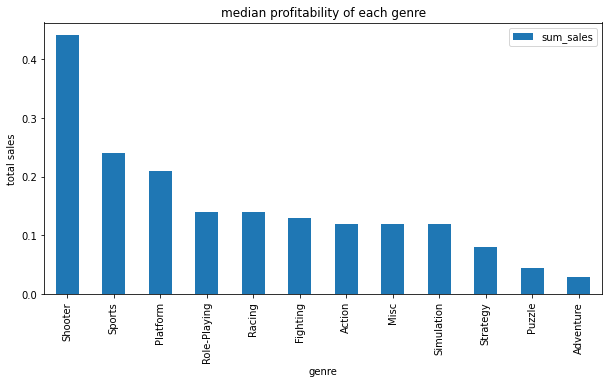

In [40]:
(df_actual
 .pivot_table(index='genre', values='sum_sales', aggfunc='median')
 .sort_values(by='sum_sales',ascending=False)
 .plot(kind='bar', y='sum_sales', figsize=(10, 5),title = 'median profitability of each genre')
 .set(xlabel='genre', ylabel='total sales'))
plt.show()

Можно заметить, что большое количество игр в жанре не всегда сопровождается высокими продажами. Например, в жанре adventure выпущено много игр, но их медианные продажи довольно низкие. С другой стороны, есть случаи, когда медианные продажи почти достигают максимума среди всех жанров, несмотря на небольшое число игр — жанр simulation служит таким примером. Если рассматривать только самые прибыльные жанры, то можно увидеть, что в них сочетается два параметра: высокий объём выпуска и значительные медианные продажи.

###### Вывод по исследовательскому анализу:

1. С 1980 года количество выпускаемых игр постепенно росло, начиная с десятков игр и достигнув пика в 2008–2009 годах (свыше 1400 игр ежегодно).
После 2010 года количество игр снижается, что может быть связано с изменениями в игровой индустрии, включая переход к цифровой дистрибуции и рост популярности мобильных игр.
Данные за более ранние периоды могут быть менее полезными из-за небольшого объёма и изменений в индустрии. Для более значимых выводов целесообразно сосредоточиться на данных с 2000-х годов


2. С помощью сводной таблицы мы рассчитали медианное значение продолжительности жизни платформы - 7


3. Согласно графику, к 2016 году продажи консолей не растут – наблюдается спад на всех моделях. Наиболее перспективными остаются PS4 и XOne, хотя и у них также прослеживается снижение продаж


4. Медианное значение по всей выборке составляет 0,18 но у большинства консолей данный показатель не совпадает с основным.


    Также можно увидеть, что у каждой консоли наблюдается значительные выбросы


5. 1. между оценками пользователей и продажами слабая связь и нелинейная

   2. между оценками критиков и продажами связь умеренная и  нелинейная


6. Можно заметить, что большое количество игр в жанре не всегда сопровождается высокими продажами. Например, в жанре adventure выпущено много игр, но их медианные продажи довольно низкие. С другой стороны, есть случаи, когда медианные продажи почти достигают максимума среди всех жанров, несмотря на небольшое число игр — жанр simulation служит таким примером. Если рассматривать только самые прибыльные жанры, то можно увидеть, что в них сочетается два параметра: высокий объём выпуска и значительные медианные продажи.

# Шаг 4.1 Портрет пользователя каждого региона¶


### Самые популярные платформы (топ-5). Опишите различия в долях продаж.


In [41]:
df_actual['genre'].unique()

array(['Action', 'Shooter', 'Role-Playing', 'Platform', 'Misc',
       'Simulation', 'Sports', 'Fighting', 'Racing', 'Strategy',
       'Adventure', 'Puzzle'], dtype=object)

In [42]:
platform_portret = df_actual.pivot_table(index='platform', values=['na_sales','eu_sales', 'jp_sales', 'sum_sales'], aggfunc='sum')
platform_portret

,eu_sales,jp_sales,na_sales,sum_sales
platform,,,,
3DS,42.64,87.79,55.31,194.61
DS,3.53,3.72,4.59,12.55
PC,37.76,0.00,19.12,62.65
PS3,106.85,35.29,103.38,288.78
PS4,141.09,15.96,108.74,314.14
PSP,0.42,10.47,0.13,11.19
PSV,11.36,21.04,10.98,49.18
Wii,11.92,3.39,17.45,35.37
WiiU,25.13,13.01,38.10,82.19


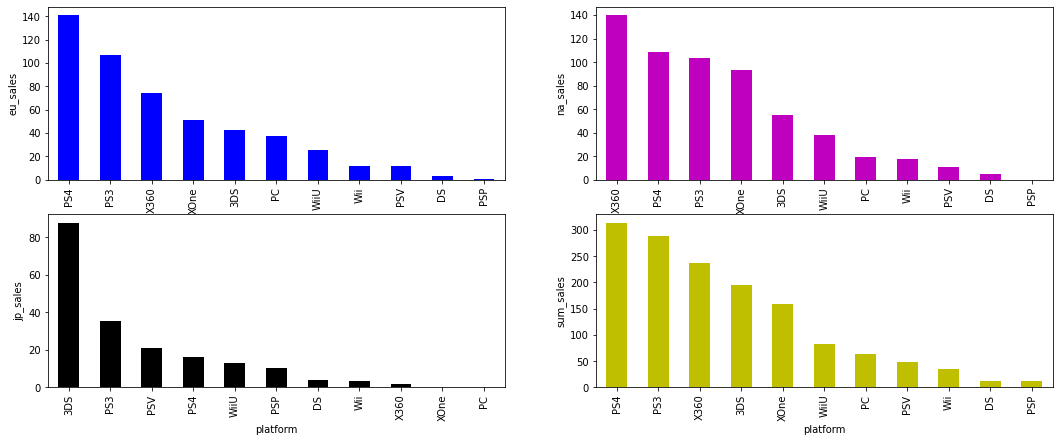

In [43]:
fig, axis = plt.subplots(2,2, figsize=(18,7))

platform_portret['eu_sales'].sort_values(ascending=False).plot.bar(ax=axis[0,0], color = 'b').set(ylabel='eu_sales');
platform_portret['na_sales'].sort_values(ascending=False).plot.bar(ax=axis[0,1], color = 'm').set(ylabel='na_sales');
platform_portret['jp_sales'].sort_values(ascending=False).plot.bar(ax=axis[1,0], color = 'k').set(ylabel='jp_sales');
platform_portret['sum_sales'].sort_values(ascending=False).plot.bar(ax=axis[1,1], color = 'y').set(ylabel='sum_sales');


In [44]:
top5_platforms = platform_portret.sort_values(by='na_sales', ascending=False).head(5)


top5_platforms['na_sales%'] = top5_platforms['na_sales'] / top5_platforms['sum_sales'] * 100
top5_platforms['eu_sales%'] = top5_platforms['eu_sales'] / top5_platforms['sum_sales'] * 100
top5_platforms['jp_sales%'] = top5_platforms['jp_sales'] / top5_platforms['sum_sales'] * 100

top5_platforms

,eu_sales,jp_sales,na_sales,sum_sales,na_sales%,eu_sales%,jp_sales%
platform,,,,,,,
X360,74.52,1.57,140.05,236.54,59.207745,31.504185,0.663736
PS4,141.09,15.96,108.74,314.14,34.615140,44.913096,5.080537
PS3,106.85,35.29,103.38,288.78,35.798878,37.000485,12.220375
XOne,51.59,0.34,93.12,159.32,58.448406,32.381371,0.213407
3DS,42.64,87.79,55.31,194.61,28.420944,21.910488,45.110734


Самые популярные платформы (топ-5)
1. EU: PS4, XOne, ps3, 3DS, X360 - Европа
2. NA: PS4, XOne, 3DS, X360, PS3 - CША
3.JP: 3DS, PS4, PSV, PS3, WiiU - Япония


В топ в регионах NA и EU входят одинаковые платформы с перестановкой их предпочтения.

Нa рынке JP присутствуют региональные платформы. Платформа 3DS занимает 45% рынка



# Шаг 4.2  Самые популярные жанры (топ-5). Поясните разницу.


In [45]:
genre_portret = df_actual.pivot_table(index='genre', values=['na_sales','eu_sales', 'jp_sales', 'sum_sales'], aggfunc='sum')
genre_portret

,eu_sales,jp_sales,na_sales,sum_sales
genre,,,,
Action,159.34,52.80,177.84,441.12
Adventure,9.46,8.24,8.92,29.43
Fighting,10.79,9.44,19.79,44.49
Misc,26.32,12.86,38.19,85.04
Platform,21.41,8.63,25.38,61.00
Puzzle,1.40,2.14,1.13,4.89
Racing,27.29,2.50,17.22,53.50
Role-Playing,48.53,65.44,64.00,192.80
Shooter,113.47,9.23,144.77,304.73


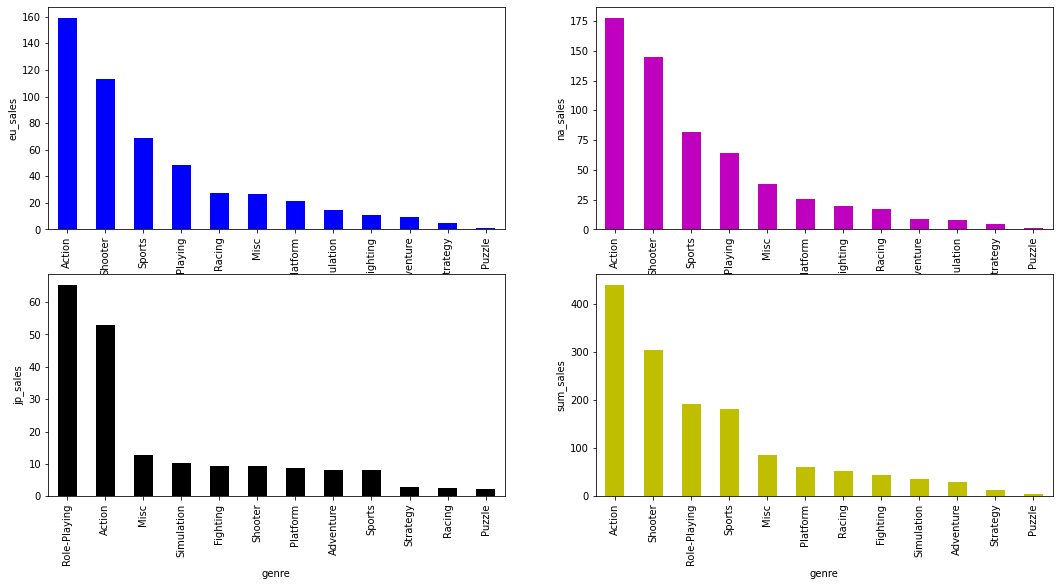

In [46]:
fig, axis = plt.subplots(2,2, figsize=(18,9))

genre_portret['eu_sales'].sort_values(ascending=False).plot.bar(ax=axis[0,0], color = 'b').set(ylabel='eu_sales');
genre_portret['na_sales'].sort_values(ascending=False).plot.bar(ax=axis[0,1], color = 'm').set(ylabel='na_sales');
genre_portret['jp_sales'].sort_values(ascending=False).plot.bar(ax=axis[1,0], color = 'k').set(ylabel='jp_sales');
genre_portret['sum_sales'].sort_values(ascending=False).plot.bar(ax=axis[1,1], color = 'y').set(ylabel='sum_sales');


In [47]:
top5_genre = genre_portret.sort_values(by='na_sales', ascending=False).head(5)


# Расчёт процентных долей продаж для каждого региона относительно суммарных продаж платформы
top5_genre['na_sales%'] = top5_genre['na_sales'] / top5_genre['sum_sales'] * 100
top5_genre['eu_sales%'] = top5_genre['eu_sales'] / top5_genre['sum_sales'] * 100
top5_genre['jp_sales%'] = top5_genre['jp_sales'] / top5_genre['sum_sales'] * 100

top5_genre

,eu_sales,jp_sales,na_sales,sum_sales,na_sales%,eu_sales%,jp_sales%
genre,,,,,,,
Action,159.34,52.80,177.84,441.12,40.315560,36.121690,11.969532
Shooter,113.47,9.23,144.77,304.73,47.507630,37.236242,3.028911
Sports,69.08,8.01,81.53,181.06,45.029272,38.153098,4.423948
Role-Playing,48.53,65.44,64.00,192.80,33.195021,25.171162,33.941909
Misc,26.32,12.86,38.19,85.04,44.908278,30.950141,15.122295


Самые популярные жанры (топ-5)

EU: Shooter, Sports, Action, Role-Playing, Racing - Европа

NA: Shooter, Action, Sports, Role-Playing, Misc - CША

JP: Action, Role-Playing, Fighting, Simulation, Misc - Япония


в регионах NA и EU  почти одинаковые жанры. На рынке JP предпочитают Role-Playing, Misc которые суммарно занимают почти 50% рынка.

# Шаг 4.3 Влияет ли рейтинг ESRB на продажи в отдельном регионе?


In [48]:
ESRB_portret = df_actual.pivot_table(index='rating', values=['na_sales','eu_sales', 'jp_sales'], aggfunc='sum')
ESRB_portret

,eu_sales,jp_sales,na_sales
rating,,,
E,113.02,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
tbd,91.50,108.84,103.31


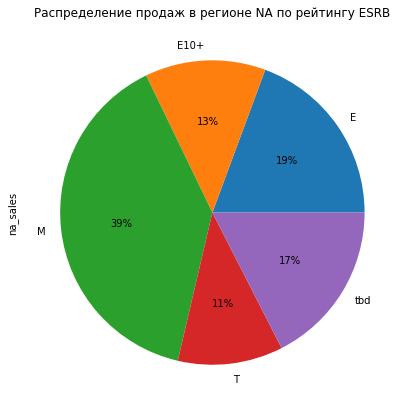

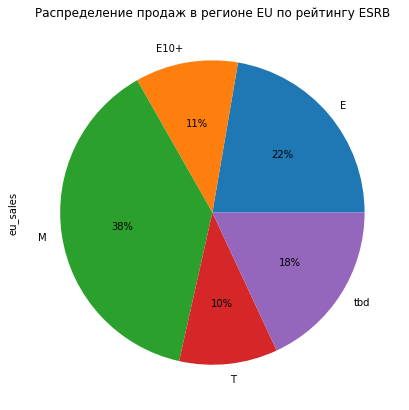

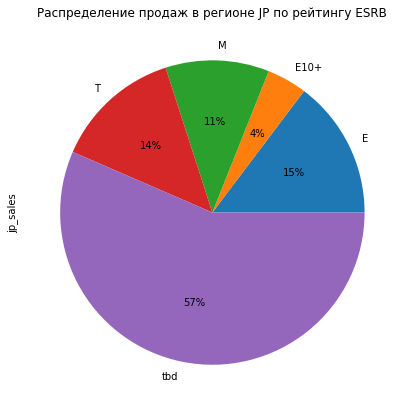

In [49]:
regions = {
    'na_sales': 'NA',
    'eu_sales': 'EU',
    'jp_sales': 'JP'
}

for i, region in regions.items():
    plt.figure(figsize=(7, 7))
    ESRB_portret[i].plot.pie(autopct='%1.0f%%')
    plt.title(f'Распределение продаж в регионе {region} по рейтингу ESRB')
    plt.show()

В регионах NA и EU большая часть продаж приходится на рейтинг "M" (для взрослых) - 38-39% на втором месте с рейтингом для всех "Е" 19-22%, на рынке JP первое место занимают игры с неуказанным рейтингом "tbd" - 57%, затем игры для всех "Е" - 15%.

Количество игр с неопределнным рейтингом (tbd) в Японии велико, так как рейтинг ESRB в этой стране не используется 

###### Вывод по портрету пользователя по каждому региону:

1. В NA и EU приблизительно одинаковые предпочтения по платформам и жанрам. Наиболее популярными платформами в данных регионах стали PS4 и X360, а жанрами- Action и Shooter. В Японии ситуация немного иная платофрма 3DS занимает почти половину рынка страны, а самыми поплярными жанрами стали Role-playing и Action

2. В регионах NA и EU большая часть продаж приходится на рейтинг "M" (для взрослых) - 38-39% на втором месте с рейтингом для всех "Е" 19-22%, на рынке JP первое место занимают игры с неуказанным рейтингом "tbd" - 57%, затем игры для всех "Е" - 15%. Количество игр с неопределнным рейтингом (tbd) в Японии велико, так как рейтинг ESRB в этой стране не используется

# Шаг 5 Проверка гипотез

Н0: Средние пользовательские рейтинги платформ XOne и PC равны

Н1: Средние пользовательские рейтинги платформ XOne и PC не равны


In [50]:
xone = df_actual.query('platform == "XOne" and user_score != 0')
pc = df_actual.query("platform == 'PC' and user_score != 0")

alpha = 0.05

results = st.ttest_ind(xone['user_score'], pc['user_score'],equal_var=False)

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу,рейтинги платформ Xbox One и PC разные')
else:
    print('Не получилось отвергнуть нулевую гипотезу,рейтинги платформ Xbox One и PC одинаковые')

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу,рейтинги платформ Xbox One и PC одинаковые


# Шаг 5.1

Н0: Средние пользовательские рейтинги жанров Action и Sports не равны

Н1: Средние пользовательские рейтинги жанров Action и Sports равны

In [55]:
action = df_actual.query('genre == "Action" and user_score > 0')
sports = df_actual.query("genre == 'Sports' and user_score > 0")

alpha = 0.05

results = st.ttest_ind(action['user_score'], sports['user_score'],equal_var=False)

print(results.pvalue)

if results.pvalue < alpha:
    print('Не получилось отвергнуть нулевую гипотезу, рейтинги жанров Action и Sports не равны')
else:
    print('Отвергаем нулевую гипотезу, рейтинги жанров Action и Sports равны')

5.989458066467418e-20
Не получилось отвергнуть нулевую гипотезу, рейтинги жанров Action и Sports не равны


# Итоговый вывод

###### А.  Предобработка данных

1. Явные дубликаты не обнаружены


2. Удалены строки с неявными дубликатами поиск одновременно по 'name', 'platform', 'year_of_release'


3. По столбцу name удалены 2 строки с пропусками


4. По столбцу year_of_release принято решение удалить строки с пропусками


5. В столбце critic_score пропуски были заменены 0


6. В столбце user_score пропуски были заменены на 0 


7. В столбце rating пропуски обозначены как tbd


8. Столбецы year_of_release, critic_score приведены к int типу, user_score к float в соответствии с данными содержащимися в них.


9. Посчитали суммарные продажи во всех регионах записали в sum_sales

###### B. Исследовательский анализ данных

1. Определили, что актуальный период составляет 5 последних года.


2. Согласно графику, к 2016 году продажи консолей не растут – наблюдается спад на всех моделях. Наиболее перспективными остаются PS4 и XOne, хотя и у них также прослеживается снижение продаж.


3. между оценками пользователей и продажами слабая связь и нелинейная


4. между оценками критиков и продажами связь умеренная и нелинейная


5. Предпочтение в жанрах стоит отдать Shooter, Sports потому что их медианное значение прибыли намного выше остальных


###### С. Портрет пользователя каждого региона
1. В NA и EU приблизительно одинаковые предпочтения по платформам и жанрам. Наиболее популярными платформами в данных регионах стали PS4 и X360, а жанрами- Action и Shooter. В Японии ситуация немного иная платофрма 3DS занимает почти половину рынка страны, а самыми поплярными жанрами стали Role-playing и Action


2. В регионах NA и EU большая часть продаж приходится на рейтинг "M" (для взрослых) - 38-39% на втором месте с рейтингом для всех "Е" 19-22%, на рынке JP первое место занимают игры с неуказанным рейтингом "tbd" - 57%, затем игры для всех "Е" - 15%. Количество игр с неопределнным рейтингом (tbd) в Японии велико, так как рейтинг ESRB в этой стране не используется

###### D. Проверка гипотез

1. Н0: Средние пользовательские рейтинги платформ XOne и PC равны

   Н1: Средние пользовательские рейтинги платформ XOne и PC не равны
   
   p-value=0.5489537965134912
   
   
   Не получилось отвергнуть нулевую гипотезу,рейтинги платформ Xbox One и PC одинаковые
   
2. Н0: Средние пользовательские рейтинги жанров Action и Sports не равны

   Н1: Средние пользовательские рейтинги жанров Action и Sports равны
   
   p-value=5.989458066467418e-20

   Не получилось отвергнуть нулевую гипотезу, рейтинги жанров Action и Sports не равны


